Evaluating on alternative worlds

In [170]:
from rnn_syn_ts import build_end2end_model, shuffle_envs_labels
import tensorflow as tf
import shapeworld_fast as sf
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
%matplotlib inline

In [20]:
t_feat_spk, t_lab_spk, t_feat_lis, t_lab_lis, \
t_msg, t_pred, t_loss, t_conv_s, t_conv_l, loss_summary_op, weights_summary_op = build_end2end_model(
        5)

ValueError: Variable enc1/rnn/gru_cell/gates/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/local/scratch/jlm95/rnn-syn/rnn_syn_ts.py", line 76, in build_end2end_model
    states1, hidden1 = tf.nn.dynamic_rnn(cell, t_in, dtype=tf.float32)
  File "<ipython-input-3-d81d82bee7ed>", line 2, in <module>
    5)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, 'saves/40k')

INFO:tensorflow:Restoring parameters from saves/40k


In [128]:
feat_spk, lab_spk, configs = sf.generate(1024, 5, 0.5, verbose=True,
                                         img_func=sf.IMG_FUNCS['single'],
                                         do_mp=False,
                                         float_type=True)
feat_lis, lab_lis = shuffle_envs_labels(feat_spk, lab_spk)

100%|██████████| 1024/1024 [00:01<00:00, 608.36it/s]


In [166]:
def batches(*args, batch_size=128):
    """
    Yield batches from `train`. Discards smallest batch sizes, like
    tf.train.Batch.
    """
    first_len = len(args[0])
    assert all(len(a) == first_len for a in args), "Args not same length"
    for i in range(0, first_len, batch_size):
        to_yield = []
        for arg in args:
            arg_batch = arg[i:i + batch_size]
            if len(arg_batch) != batch_size:
                break
            to_yield.append(arg_batch)
        else:
            yield tuple(to_yield)

In [171]:
msgs = []
preds = []
conv_s = []
conv_l = []
for feat_spk_b, lab_spk_b, feat_lis_b, lab_lis_b in batches(feat_spk, lab_spk, feat_lis, lab_lis, 
                                                            batch_size=128):
    msgs_b, preds_b, conv_s_b, conv_l_b = session.run(
        [t_msg, t_pred, t_conv_s, t_conv_l], {
            t_feat_spk: feat_spk_b,
            t_lab_spk: lab_spk_b,
            t_feat_lis: feat_lis_b,
        })
    msgs.append(msgs_b)
    preds.append(preds_b)
    conv_s.append(conv_s_b)
    conv_l.append(conv_l_b)
msgs = np.concatenate(msgs)
preds = np.concatenate(preds)
conv_s = np.concatenate(conv_s)
conv_l = np.concatenate(conv_l)

In [205]:
def config_type(c):
    if c[0] is not None and c[1] is not None:
        return 'both'
    if c[0] is None:
        return 'shape_only'
    if c[1] is None:
        return 'color_only'

In [206]:
print(configs[0])
config_type(configs[0])

('gray', None)


'color_only'

In [207]:
msgs_pca = PCA(2).fit_transform(msgs)
if True:
    msgs_df = pd.DataFrame({
        'x': msgs_pca[:, 0],
        'y': msgs_pca[:, 1],
        'color': [s[0] for s in configs],
        'shape': [s[1] for s in configs],
        'config': [config_type(s) for s in configs],
    })
else:
    msgs_df = pd.DataFrame({
        'x': msgs_pca[:, 0],
        'y': msgs_pca[:, 1],
        's1_color': [s[0][0][0] for s in configs],
        's1_shape': [s[0][0][1] for s in configs],
        's2_color': [s[0][1][0] for s in configs],
        's2_shape': [s[0][1][1] for s in configs],
        'relation': [s[2] for s in configs],
        'relation_dir': [s[3] for s in configs],
        'relation_pair': [(s[2], s[3]) for s in configs]
    })

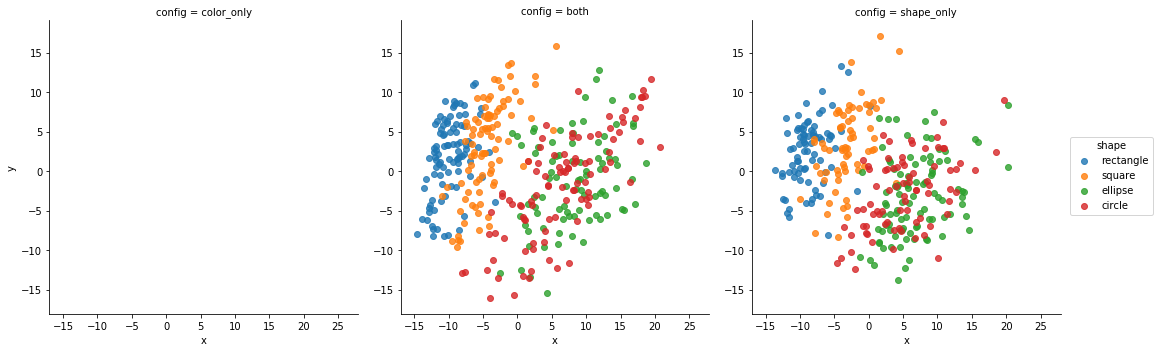

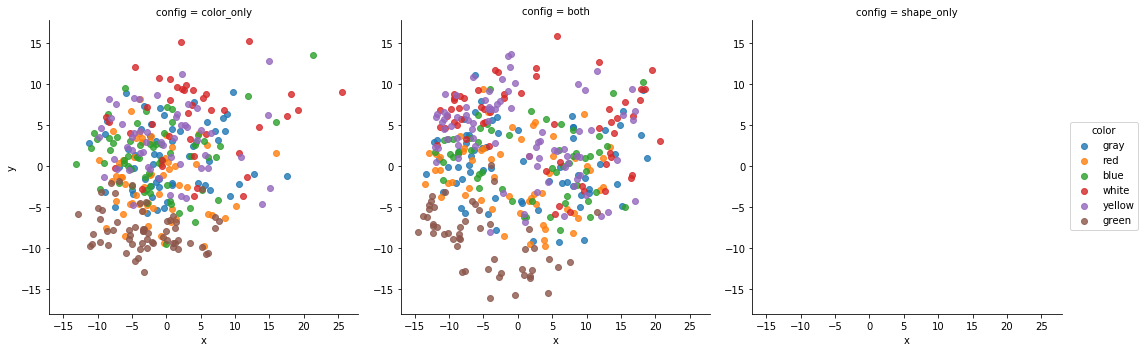

In [208]:
import seaborn as sns
sns.lmplot('x', 'y', data=msgs_df, hue='shape', fit_reg=False,
          col='config')
sns.lmplot('x', 'y', data=msgs_df, hue='color', fit_reg=False,
          col='config')

In [ ]:
# Review previous work on metaphor...
# discard top 3 embeddings...review previous work on RSA...
# discourse modeling
# WE SHOULD INCLUDE THEM!!! :) PREDECESSOR. . . . . . . . .
# WE SHOULD INCLUDE THEM!!! :) PREDECESSOR. . . . . . . . .